## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [3]:
pip install kaggle --upgrade


The following command must be run outside of the IPython shell:

    $ pip install kaggle --upgrade

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [6]:
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

Syntaxfehler.
mv: cannot move 'kaggle.json' to '~/.kaggle/': No such file or directory


In [7]:
%pwd

'D:\\FastaiV3\\nbs\\dl1'

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [3]:
path = Path('data/planet')
path

WindowsPath('data/planet')

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip` in your terminal).

In [ ]:
# ! conda install -y -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [ ]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [8]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

AttributeError: 'LazyConfigValue' object has no attribute 'lower'

  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageItemList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [9]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [10]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [12]:
data = (src.transform(tfms, size=64, bs=16)
        .databunch().normalize(imagenet_stats))

c:\users\gerst\appdata\local\programs\python\python37\lib\site-packages\fastai\basic_data.py:226: UserWarning: There seems to be something wrong with your dataset, can't access any element of self.train_ds.
Tried: 22480,21433,13890,11564,25479...
  warn(warn_msg)


You can deactivate this warning by passing `no_check=True`.


`show_batch` still works, and show us the different labels separated by `;`.

In [13]:
data.show_batch(rows=3, figsize=(12,9))

TypeError: Traceback (most recent call last):
  File "c:\users\gerst\appdata\local\programs\python\python37\lib\site-packages\torch\utils\data\dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "c:\users\gerst\appdata\local\programs\python\python37\lib\site-packages\torch\utils\data\dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "c:\users\gerst\appdata\local\programs\python\python37\lib\site-packages\fastai\data_block.py", line 567, in __getitem__
    x = x.apply_tfms(self.tfms, **self.tfmargs)
TypeError: apply_tfms() got an unexpected keyword argument 'bs'


To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [8]:
arch = models.resnet50

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


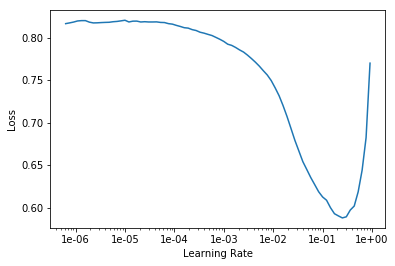

In [41]:
learn.recorder.plot()

Then we can fit the head of our network.

In [42]:
lr = 0.01

In [43]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.126455,0.113216,0.945711,0.901465
2,0.109298,0.100570,0.953050,0.911658
3,0.103564,0.093699,0.949853,0.916843
4,0.095877,0.088493,0.954823,0.922914
5,0.091399,0.087219,0.955978,0.923727


In [44]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [45]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


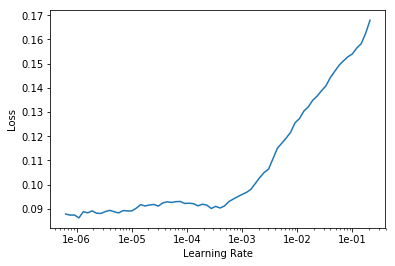

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.095857,0.090147,0.954017,0.922100
2,0.093944,0.090078,0.955150,0.921380
3,0.090945,0.086659,0.957970,0.924858
4,0.085740,0.083959,0.959401,0.928692
5,0.081346,0.082736,0.959038,0.929355


In [48]:
learn.save('stage-2-rn50')

In [10]:
learn.load('stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: data\planet
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: data\planet;

Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: data\planet
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: data\planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel

In [11]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [12]:
learn.freeze()

In [13]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 6.00 GiB total capacity; 4.52 GiB already allocated; 114.39 MiB free; 634.50 KiB cached)

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageItemList.from_folder(path/'test-jpg').add(ImageItemList.from_folder(path/'test-jpg-additional'))
len(test)

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

Private Leaderboard score: 0.9296 (around 80th)